In [3]:
# BLOCK 1 – Configuration Block (edit only DATA_ROOT)
from pathlib import Path
import os, time, pickle, hashlib
import numpy as np
from math import ceil
from tqdm import tqdm
from collections import defaultdict

# ---------- EDIT IF NEEDED ----------
DATA_ROOT = "data"  # ✅ Changed to mango disease folders
# ------------------------------------

# Cache & artifact locations
CACHE_DIR = Path('./embeddings_cache')
CACHE_DIR.mkdir(exist_ok=True)
EMB_FILE = CACHE_DIR / 'X_emb.npy'
LBL_FILE = CACHE_DIR / 'y_lbl.npy'
PATHS_FILE = CACHE_DIR / 'paths.npy'
CLF_FILE = CACHE_DIR / 'svc_model.pkl'
CENTROIDS_FILE = CACHE_DIR / 'centroids.npy'
CLASSES_FILE = CACHE_DIR / 'classes.npy'

# Image extensions
EXTS = {'.jpg', '.jpeg', '.png'}
IMAGE_SIZE = (224, 224)  # ✅ Changed from 160x160
print("DATA_ROOT:", DATA_ROOT)

DATA_ROOT: data


In [4]:
# Block 2 – Load EfficientNet model
try:
    import torch
    import timm
    import cv2
    from PIL import Image
    import albumentations as A
except Exception as e:
    raise ImportError("Missing packages. Run: pip install timm torch opencv-python albumentations") from e

device = 'cpu'
print(f"Using device: {device}")

# Load EfficientNet-B4 pre-trained on ImageNet
model = timm.create_model('efficientnet_b4', pretrained=True, num_classes=0)  # Feature extraction mode
model.eval()
model.to(device)

print(f"✅ Model loaded: EfficientNet-B4")
print(f"   Feature dimension: {model.num_features}")

Using device: cpu
✅ Model loaded: EfficientNet-B4
   Feature dimension: 1792


In [5]:
from pathlib import Path

# Explicitly point to the 'data' folder
image_path = Path("data")

# Use rglob to find images even if they are in subfolders within 'data'
# The '*' catches any filename, and suffix check handles extension cases
images = [f for f in image_path.rglob("*") if f.suffix.lower() in [".png", ".jpg", ".jpeg"]]

print(f"Found {len(images)} images in {image_path.absolute()}")

Found 4000 images in D:\DATA_SCIENCE\My_Projects\completed\Git_Repositories\Mango_Plant_Diseases_Detection\data


In [6]:
import numpy as np
from pathlib import Path
import os

# --- 1. CONFIGURATION ---
# The root folder containing your mango disease subfolders
ROOT = Path("data")

# Define allowed extensions to avoid picking up system files (.DS_Store, etc.)
EXTS = {'.jpg', '.jpeg', '.png', '.webp', '.bmp'}

# Define where to save the cached paths for future use
CACHE_DIR = Path("embeddings_cache")
CACHE_DIR.mkdir(exist_ok=True)
PATHS_FILE = CACHE_DIR / "paths.npy"

# --- 2. IMAGE DISCOVERY ---
print(f"Scanning directory: {ROOT.absolute()}...")

# Build image_paths and labels
image_paths = [
    str(p) for p in sorted(ROOT.rglob('*'))
    if p.suffix.lower() in EXTS
]

# In this project, the parent folder name is the Disease Class
labels = [Path(p).parent.name for p in image_paths]

# --- 3. SUMMARY & SAVING ---
unique_classes = sorted(list(set(labels)))
print("-" * 30)
print(f"✅ Classes found ({len(unique_classes)}): {unique_classes}")
print(f"✅ Total images indexed: {len(image_paths)}")
print("-" * 30)

# Save list of paths to allow deduping later or resuming training
np.save(str(PATHS_FILE), np.array(image_paths, dtype=object))
print(f"💾 Saved paths cache to: {PATHS_FILE}")

Scanning directory: D:\DATA_SCIENCE\My_Projects\completed\Git_Repositories\Mango_Plant_Diseases_Detection\data...
------------------------------
✅ Classes found (8): ['Anthracnose', 'Bacterial Canker', 'Cutting Weevil', 'Die Back', 'Gall Midge', 'Healthy', 'Powdery Mildew', 'Sooty Mould']
✅ Total images indexed: 4000
------------------------------
💾 Saved paths cache to: embeddings_cache\paths.npy


In [7]:
# Block 5: (Embedding Block)
# Batched, resumable extraction to EMB_FILE / LBL_FILE (overwrite/resume)
# Block 5: Feature Extraction (no face detection needed)
import numpy as np
import torch
from PIL import Image
from math import ceil
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Parameters
BATCH_SIZE = 32
SAVE_EVERY = 5
MAX_SIDE = 640

# Load paths
image_paths = list(np.load(PATHS_FILE, allow_pickle=True))
n_total = len(image_paths)

# Resume from cache if exists
if EMB_FILE.exists() and LBL_FILE.exists():
    X_cached = np.load(EMB_FILE)
    y_cached = np.load(LBL_FILE, allow_pickle=True)
    start_idx = len(y_cached)
    X_list = [X_cached[i] for i in range(len(X_cached))]
    y_list = list(y_cached)
    print(f"Resuming from cache: {start_idx} embeddings loaded.")
else:
    X_list = []
    y_list = []
    start_idx = 0

# Image preprocessing transform
transform = A.Compose([
    A.Resize(IMAGE_SIZE[0], IMAGE_SIZE[1]),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

def safe_open_and_transform(path):
    try:
        img = Image.open(path).convert('RGB')
        img_np = np.array(img)
        transformed = transform(image=img_np)
        return transformed['image']
    except Exception:
        return None

pairs = image_paths[start_idx:]
n = len(pairs)

if n == 0:
    print("No new images to process.")
else:
    n_batches = ceil(n / BATCH_SIZE)
    print(f"Processing {n} images in {n_batches} batches (batch_size={BATCH_SIZE})")
    bad_files = []
    batch_count = 0
    
    for b in tqdm(range(n_batches), desc='Batches'):
        s = b * BATCH_SIZE
        e = min(s + BATCH_SIZE, n)
        batch_paths = pairs[s:e]
        
        batch_tensors = []
        batch_labels = []
        
        for path in batch_paths:
            tensor = safe_open_and_transform(path)
            if tensor is None:
                bad_files.append(path)
                continue
            batch_tensors.append(tensor)
            batch_labels.append(Path(path).parent.name)
        
        if not batch_tensors:
            batch_count += 1
            continue
        
        # Stack into batch
        batch = torch.stack(batch_tensors).to(device)
        
        # Extract features
        try:
            with torch.no_grad():
                features = model(batch).cpu().numpy()
        except Exception:
            bad_files.extend([pairs[s + i] for i in range(len(batch_tensors))])
            batch_count += 1
            continue
        
        # Save features
        for feat, label in zip(features, batch_labels):
            X_list.append(feat.astype('float32'))
            y_list.append(label)
        
        batch_count += 1
        if batch_count % SAVE_EVERY == 0:
            np.save(EMB_FILE, np.vstack(X_list))
            np.save(LBL_FILE, np.array(y_list, dtype=object))
            print(f"Saved cache: {len(y_list)} embeddings")
    
    # Final save
    if len(X_list) > 0:
        X = np.vstack(X_list).astype('float32')
        y = np.array(y_list, dtype=object)
        np.save(EMB_FILE, X)
        np.save(LBL_FILE, y)
        print("Done. Extracted embeddings:", X.shape)
    
    if bad_files:
        bad_txt = CACHE_DIR / 'bad_files.txt'
        with open(bad_txt, 'w') as f:
            for p in sorted(set(bad_files)):
                f.write(p + "\n")
        print(f"{len(set(bad_files))} problematic files logged")

Resuming from cache: 4000 embeddings loaded.
No new images to process.


📊 CLASS BALANCE ANALYSIS
Total classes: 8
Total samples: 4000
Min samples per class: 500
Max samples per class: 500
Mean samples per class: 500.0
Median samples per class: 500.0
Imbalance ratio: 1.00x

✅ Dataset is BALANCED (ratio 1.00x ≤ 1.5x)
   No augmentation needed!

📉 CLASSES WITH FEWEST SAMPLES (Bottom 10)
  Anthracnose: 500 samples
  Bacterial Canker: 500 samples
  Cutting Weevil: 500 samples
  Die Back: 500 samples
  Gall Midge: 500 samples
  Healthy: 500 samples
  Powdery Mildew: 500 samples
  Sooty Mould: 500 samples

📈 CLASSES WITH MOST SAMPLES (Top 10)
  Anthracnose: 500 samples
  Bacterial Canker: 500 samples
  Cutting Weevil: 500 samples
  Die Back: 500 samples
  Gall Midge: 500 samples
  Healthy: 500 samples
  Powdery Mildew: 500 samples
  Sooty Mould: 500 samples


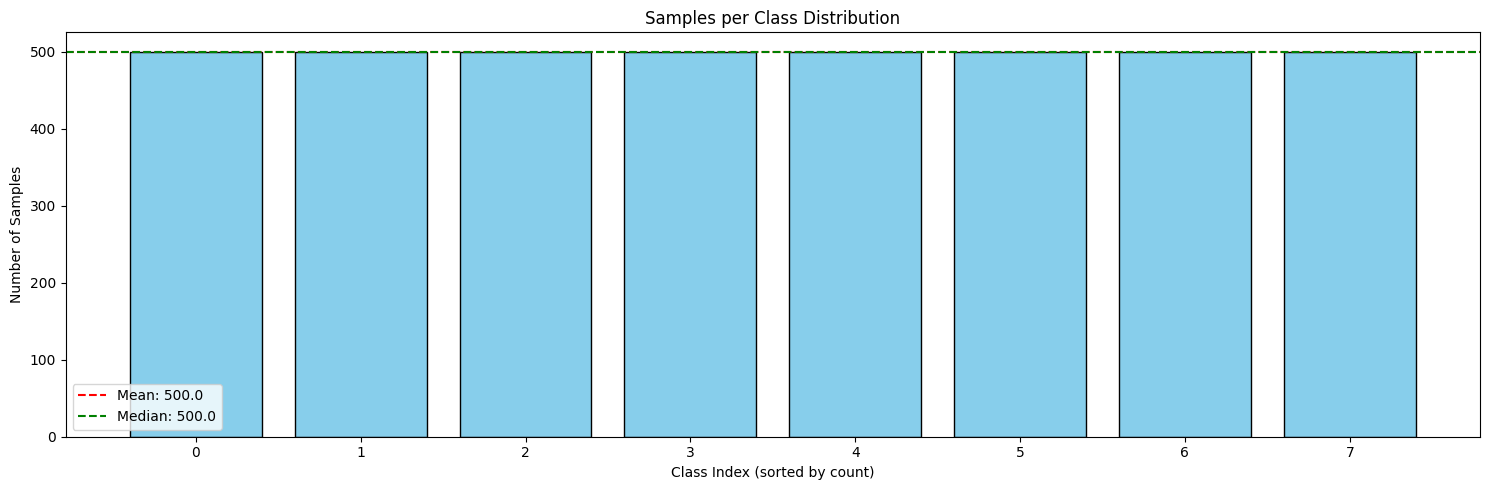


✅ Distribution plot saved as: class_distribution.png
✅ Detailed balance report saved as: class_balance_report.csv


In [8]:
################################################################################
# Block 6A - Check Class Balance (FAST - no processing needed)
################################################################################
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

# Load existing embeddings and labels
X = np.load(EMB_FILE)
y = np.load(LBL_FILE, allow_pickle=True)

# Count samples per class
class_counts = Counter(y)
class_counts_sorted = sorted(class_counts.items(), key=lambda x: x[1])

# Statistics
min_samples = min(class_counts.values())
max_samples = max(class_counts.values())
mean_samples = np.mean(list(class_counts.values()))
median_samples = np.median(list(class_counts.values()))

print("="*80)
print("📊 CLASS BALANCE ANALYSIS")
print("="*80)
print(f"Total classes: {len(class_counts)}")
print(f"Total samples: {len(y)}")
print(f"Min samples per class: {min_samples}")
print(f"Max samples per class: {max_samples}")
print(f"Mean samples per class: {mean_samples:.1f}")
print(f"Median samples per class: {median_samples:.1f}")
print(f"Imbalance ratio: {max_samples/min_samples:.2f}x")

# Define balance threshold
BALANCE_THRESHOLD = 1.5  # If max/min > 1.5x, consider imbalanced
IS_BALANCED = (max_samples / min_samples) <= BALANCE_THRESHOLD

if IS_BALANCED:
    print(f"\n✅ Dataset is BALANCED (ratio {max_samples/min_samples:.2f}x ≤ {BALANCE_THRESHOLD}x)")
    print("   No augmentation needed!")
else:
    print(f"\n⚠️ Dataset is IMBALANCED (ratio {max_samples/min_samples:.2f}x > {BALANCE_THRESHOLD}x)")
    print("   Augmentation recommended! Run Block 6B below.")

# Show classes with fewest samples
print("\n" + "="*80)
print("📉 CLASSES WITH FEWEST SAMPLES (Bottom 10)")
print("="*80)
for class_name, count in class_counts_sorted[:10]:
    print(f"  {class_name}: {count} samples")

# Show classes with most samples
print("\n" + "="*80)
print("📈 CLASSES WITH MOST SAMPLES (Top 10)")
print("="*80)
for class_name, count in class_counts_sorted[-10:]:
    print(f"  {class_name}: {count} samples")

# Visualize distribution
plt.figure(figsize=(15, 5))
counts = [count for _, count in class_counts_sorted]
plt.bar(range(len(counts)), counts, color='skyblue', edgecolor='black')
plt.axhline(y=mean_samples, color='red', linestyle='--', label=f'Mean: {mean_samples:.1f}')
plt.axhline(y=median_samples, color='green', linestyle='--', label=f'Median: {median_samples:.1f}')
plt.xlabel('Class Index (sorted by count)')
plt.ylabel('Number of Samples')
plt.title('Samples per Class Distribution')
plt.legend()
plt.tight_layout()
plt.savefig('class_distribution.png', dpi=100, bbox_inches='tight')
plt.show()

print("\n✅ Distribution plot saved as: class_distribution.png")
print("="*80)

# Save balance report
balance_report = []
for class_name, count in sorted(class_counts.items()):
    balance_report.append({
        'class': class_name,
        'samples': count,
        'percentage': f"{count/len(y)*100:.2f}%",
        'status': '✓ Good' if count >= mean_samples*0.7 else '⚠ Low'
    })

balance_df = pd.DataFrame(balance_report)
balance_df.to_csv('class_balance_report.csv', index=False)
print(f"✅ Detailed balance report saved as: class_balance_report.csv")



In [9]:
################################################################################
# Block 6B - Smart Augmentation (Embedding-Level) (cache-aware incremental augment)
################################################################################
print("\n\n" + "="*80)
print("🔄 SMART AUGMENTATION (Embedding-Level)")
print("="*80)

# ---- imports ----
import numpy as np
import pandas as pd
from collections import Counter
from pathlib import Path
from tqdm import tqdm
import sys, os

# ---- Helpers: locate CACHE_DIR (try existing variable else default) ----
try:
    CACHE_DIR
except NameError:
    CACHE_DIR = Path('embeddings_cache')
CACHE_DIR = Path(CACHE_DIR)
CACHE_DIR.mkdir(parents=True, exist_ok=True)

# candidate paths (try to preserve earlier names if present in workspace)
emb_cache = CACHE_DIR / 'X_emb_augmented.npy'
lbl_cache = CACHE_DIR / 'y_lbl_augmented.npy'
paths_cache = CACHE_DIR / 'paths_augmented.npy'
augmentation_report_csv = Path('augmentation_report.csv')

# Try loading embeddings/labels/paths either from workspace variables or files
def _load_var_or_file(varnames, candidates, label):
    g = globals()
    for n in varnames:
        if n in g and g[n] is not None:
            return g[n], f"variable '{n}'"
    for c in candidates:
        if c is None:
            continue
        p = Path(c)
        if p.exists():
            val = np.load(p, allow_pickle=True)
            return val, f"file: {p}"
    raise NameError(f"{label} not found (tried vars {varnames} and files {candidates})")

# Attempt to find X, y, paths in globals or in common files
emb_candidates = [emb_cache, 'X_emb.npy', 'X.npy', 'embeddings.npy']
lbl_candidates = [lbl_cache, 'y_lbl.npy', 'y.npy', 'labels.npy']
paths_candidates = [paths_cache, 'paths.npy']

try:
    X, X_source = _load_var_or_file(['X', 'X_emb', 'embeddings', 'embs'], emb_candidates, "embeddings (X)")
    print(f"✅ Loaded embeddings X from {X_source}")
except Exception as e:
    raise RuntimeError(str(e) + "\nMake sure embeddings exist in memory as X or as a file.") from None

try:
    y, y_source = _load_var_or_file(['y', 'y_lbl', 'labels', 'y_labels'], lbl_candidates, "labels (y)")
    print(f"✅ Loaded labels y from {y_source}")
except Exception as e:
    raise RuntimeError(str(e) + "\nMake sure labels exist in memory as y or as a file.") from None

try:
    paths, paths_source = _load_var_or_file(['paths', 'img_paths', 'paths_arr'], paths_candidates, "paths")
    print(f"✅ Loaded 'paths' from {paths_source}")
except Exception:
    # fallback: create dummy paths (so code runs)
    n_items = len(y) if 'y' in globals() else len(X)
    paths = np.array([f"idx_{i}" for i in range(n_items)], dtype=object)
    print("⚠️ 'paths' not found — created placeholder path names.")

# ---- compute current class stats (base dataset) ----
unique_classes, counts = np.unique(y, return_counts=True)
min_samples = int(counts.min())
max_samples = int(counts.max())
imb_ratio = max_samples / min_samples
IS_BALANCED = imb_ratio <= 1.5

if not IS_BALANCED:
    print("⚠️ Your dataset is imbalanced. Proceeding with augmentation...")
    PROCEED_WITH_AUGMENTATION = True
else:
    print("✅ Dataset is balanced. Skipping augmentation.")
    PROCEED_WITH_AUGMENTATION = False

if PROCEED_WITH_AUGMENTATION:
    # ---- configuration / performance ----
    TARGET_SAMPLES = max_samples              # dynamic: balance to current max class size
    MIN_SAMPLES_FOR_AUGMENT = 150             # informational only
    AUG_BATCH = 128                           # batch size for synthetic generation
    NOISE_STD = 0.01                          # gaussian noise stddev added to synthetic
    print(f"🎯 Target: {TARGET_SAMPLES} samples per class  (dynamic)")
    print(f"📊 Current range: {min_samples} - {max_samples} samples")
    print(f"🔧 Will augment classes with < {TARGET_SAMPLES} samples (actual target)")

    # If augmented cache exists, load it. We will check its balance and possibly incrementally augment.
    if emb_cache.exists() and lbl_cache.exists() and paths_cache.exists():
        print("⏱️ Augmented cache detected — loading augmented artifacts from cache.")
        X_augmented = np.load(emb_cache, allow_pickle=True)
        y_augmented = np.load(lbl_cache, allow_pickle=True)
        paths_augmented = np.load(paths_cache, allow_pickle=True)

        # Compute balance on cached augmented data
        cached_counts = Counter(y_augmented)
        cached_min = min(cached_counts.values())
        cached_max = max(cached_counts.values())
        print(f"\nCached augmented data range: {cached_min} - {cached_max} samples (imbalance {cached_max/cached_min:.2f}x)")

        # If cache is already fully balanced to TARGET_SAMPLES, skip. Otherwise do incremental augmentation.
        if cached_min >= TARGET_SAMPLES and cached_max <= TARGET_SAMPLES:
            print("✅ Cached augmented dataset already meets TARGET_SAMPLES for all classes. No further augmentation required.")
        else:
            # We'll only generate the missing samples per class to reach TARGET_SAMPLES
            print("🔁 Cached dataset still imbalanced vs TARGET_SAMPLES — performing incremental augmentation for missing classes...")
            incremental_stats = []

            # Build a dictionary mapping class -> current count in cached set
            class_to_count = {c: cached_counts.get(c, 0) for c in unique_classes}

            # For speed, convert X_augmented to list for append, same for labels/paths
            X_list = list(X_augmented)
            y_list = list(y_augmented)
            paths_list = list(paths_augmented)

            for class_name in tqdm(unique_classes, desc='Processing classes for incremental augmentation'):
                current = class_to_count.get(class_name, 0)
                if current >= TARGET_SAMPLES:
                    continue  # already enough
                needed = TARGET_SAMPLES - current
                synthetic_count = 0

                # Get originals for this class from the original X,y (not from cache) — better variation
                mask_orig = (y == class_name)
                orig_embs = X[mask_orig]
                if len(orig_embs) == 0:
                    # if original dataset had 0, fallback to using class embeddings from cached set
                    mask_cache = (y_augmented == class_name)
                    orig_embs = X_augmented[mask_cache]
                    if len(orig_embs) == 0:
                        print(f"⚠️ No originals found for class '{class_name}' in either original or cached data. Skipping.")
                        continue

                emb_indices = np.arange(len(orig_embs))
                synth_idx = 0

                while synthetic_count < needed:
                    batch = int(min(AUG_BATCH, needed - synthetic_count))

                    if len(emb_indices) == 1:
                        idx1 = idx2 = np.zeros(batch, dtype=int)
                    else:
                        idx1 = np.random.choice(emb_indices, size=batch, replace=True)
                        idx2 = np.random.choice(emb_indices, size=batch, replace=True)

                    emb1 = orig_embs[idx1]
                    emb2 = orig_embs[idx2]

                    alphas = np.random.uniform(0.3, 0.7, size=(batch, 1))
                    synthetics = alphas * emb1 + (1 - alphas) * emb2
                    noise = np.random.normal(0.0, NOISE_STD, size=synthetics.shape)
                    synthetics = synthetics + noise

                    norms = np.linalg.norm(synthetics, axis=1, keepdims=True)
                    norms[norms == 0] = 1.0
                    synthetics = synthetics / norms

                    for i in range(batch):
                        X_list.append(synthetics[i].astype('float32'))
                        y_list.append(class_name)
                        paths_list.append(f"incremental_synth_{class_name}_{synth_idx}")
                        synth_idx += 1

                    synthetic_count += batch

                incremental_stats.append({
                    'class': class_name,
                    'original_in_cache': current,
                    'added': synthetic_count,
                    'new_total': current + synthetic_count
                })
                # update cached count for this class so subsequent checks use updated value
                class_to_count[class_name] = current + synthetic_count

            # Convert lists back to arrays
            X_augmented = np.array(X_list, dtype='float32')
            y_augmented = np.array(y_list, dtype=object)
            paths_augmented = np.array(paths_list, dtype=object)

            # Update augmentation report: combine previous report (if exists) with incremental report
            if augmentation_report_csv.exists():
                try:
                    prev_df = pd.read_csv(augmentation_report_csv)
                except Exception:
                    prev_df = pd.DataFrame()
            else:
                prev_df = pd.DataFrame()

            if incremental_stats:
                inc_df = pd.DataFrame(incremental_stats)
                # If prev_df has same classes, add added counts to previous synthetic; otherwise concat
                if not prev_df.empty:
                    prev_df = prev_df.set_index('class')
                    inc_df = inc_df.set_index('class')
                    for cls in inc_df.index:
                        if cls in prev_df.index:
                            prev_row = prev_df.loc[cls].to_dict()
                            # update synthetic & total
                            prev_df.at[cls, 'synthetic'] = int(prev_df.at[cls, 'synthetic']) + int(inc_df.at[cls, 'added'])
                            prev_df.at[cls, 'total'] = int(prev_df.at[cls, 'total']) + int(inc_df.at[cls, 'added'])
                        else:
                            prev_df = pd.concat([prev_df, pd.DataFrame({
                                'original': [inc_df.at[cls, 'original_in_cache']],
                                'synthetic': [inc_df.at[cls, 'added']],
                                'total': [inc_df.at[cls, 'new_total']]
                            }, index=[cls])])
                    prev_df = prev_df.reset_index().rename(columns={'index': 'class'})
                    final_report_df = prev_df
                else:
                    inc_df = inc_df.reset_index().rename(columns={'index': 'class'})
                    final_report_df = inc_df
                final_report_df.to_csv(augmentation_report_csv, index=False)
                print("\n✅ Incremental augmentation completed and augmentation_report.csv updated.")
                try:
                    print(final_report_df.to_string(index=False))
                except Exception:
                    pass
            else:
                print("ℹ️ No incremental augmentation was needed (cache already met TARGET_SAMPLES).")

            # Save updated caches
            np.save(emb_cache, X_augmented)
            np.save(lbl_cache, y_augmented)
            np.save(paths_cache, paths_augmented)
            print("\n✅ Cache files updated with incremental augmentations.")

    else:
        # No cache exists: perform full augmentation up to TARGET_SAMPLES (same approach as incremental)
        print("🔄 No augmented cache found — generating full augmented dataset up to TARGET_SAMPLES...")
        X_list = []
        y_list = []
        paths_list = []
        augmentation_stats = []

        for class_name in tqdm(unique_classes, desc='Processing classes'):
            mask_orig = (y == class_name)
            orig_embs = X[mask_orig]
            orig_paths = np.array(paths)[mask_orig]
            current_count = len(orig_embs)

            # add originals
            X_list.extend(orig_embs)
            y_list.extend([class_name] * current_count)
            paths_list.extend(orig_paths.tolist())

            if current_count < TARGET_SAMPLES:
                needed_total = TARGET_SAMPLES - current_count
                synthetic_count = 0
                emb_indices = np.arange(len(orig_embs))
                syn_idx = 0

                if len(emb_indices) == 0:
                    print(f"⚠️ Class '{class_name}' has 0 originals — skipping.")
                    continue

                while synthetic_count < needed_total:
                    batch = int(min(AUG_BATCH, needed_total - synthetic_count))

                    if len(emb_indices) == 1:
                        idx1 = idx2 = np.zeros(batch, dtype=int)
                    else:
                        idx1 = np.random.choice(emb_indices, size=batch, replace=True)
                        idx2 = np.random.choice(emb_indices, size=batch, replace=True)

                    emb1 = orig_embs[idx1]
                    emb2 = orig_embs[idx2]

                    alphas = np.random.uniform(0.3, 0.7, size=(batch, 1))
                    synthetics = alphas * emb1 + (1 - alphas) * emb2
                    noise = np.random.normal(0.0, NOISE_STD, size=synthetics.shape)
                    synthetics = synthetics + noise

                    norms = np.linalg.norm(synthetics, axis=1, keepdims=True)
                    norms[norms == 0] = 1.0
                    synthetics = synthetics / norms

                    for i in range(batch):
                        X_list.append(synthetics[i].astype('float32'))
                        y_list.append(class_name)
                        paths_list.append(f"synthetic_{class_name}_{syn_idx}")
                        syn_idx += 1

                    synthetic_count += batch

                augmentation_stats.append({
                    'class': class_name,
                    'original': current_count,
                    'synthetic': synthetic_count,
                    'total': current_count + synthetic_count
                })

        # convert and save
        X_augmented = np.array(X_list, dtype='float32')
        y_augmented = np.array(y_list, dtype=object)
        paths_augmented = np.array(paths_list, dtype=object)

        np.save(emb_cache, X_augmented)
        np.save(lbl_cache, y_augmented)
        np.save(paths_cache, paths_augmented)

        if augmentation_stats:
            aug_df = pd.DataFrame(augmentation_stats)
            aug_df.to_csv(augmentation_report_csv, index=False)
            print("\n✅ Augmentation complete and report saved.")
            print(aug_df.to_string(index=False))
        else:
            print("\nℹ️ No augmentation stats recorded (unexpected if dataset was imbalanced).")

    # ---- report final balance status ----
    new_counts = Counter(np.load(lbl_cache, allow_pickle=True))
    new_min = min(new_counts.values())
    new_max = max(new_counts.values())

    print("\n" + "="*80)
    print("📊 NEW BALANCE STATUS")
    print("="*80)
    print(f"Min samples per class: {new_min}")
    print(f"Max samples per class: {new_max}")
    print(f"New imbalance ratio: {new_max/new_min:.2f}x")

    if new_max / new_min <= 1.5:
        print("✅ Dataset is now BALANCED!")
    else:
        print("⚠️ Still some imbalance (consider increasing TARGET_SAMPLES or re-running augmentation)")

    print("\n" + "="*80)
    print("📁 AUGMENTED FILES SAVED:")
    print("="*80)
    print(f"✅ {emb_cache}")
    print(f"✅ {lbl_cache}")
    print(f"✅ {paths_cache}")

    print("\n" + "="*80)
    print("⚠️ IMPORTANT: Update Block 7 (training) to use augmented files:")
    print("="*80)
    print("Change these lines in Block 7:")
    print("  FROM:")
    print("    EMB_SRC = EMB_FILE")
    print("    LBL_SRC = LBL_FILE")
    print("  TO:")
    print("    EMB_SRC = CACHE_DIR / 'X_emb_augmented.npy'")
    print("    LBL_SRC = CACHE_DIR / 'y_lbl_augmented.npy'")
    print("="*80)

else:
    print("\n✅ No augmentation performed. Dataset is already balanced!")
    print("   You can proceed directly to Block 7 (training).")




🔄 SMART AUGMENTATION (Embedding-Level)
✅ Loaded embeddings X from variable 'X'
✅ Loaded labels y from variable 'y'
⚠️ 'paths' not found — created placeholder path names.
✅ Dataset is balanced. Skipping augmentation.

✅ No augmentation performed. Dataset is already balanced!
   You can proceed directly to Block 7 (training).


In [10]:
# Block 7 – train classifier (SVM)
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Use augmented data if available
EMB_SRC = CACHE_DIR / 'X_emb_augmented.npy' if (CACHE_DIR / 'X_emb_augmented.npy').exists() else EMB_FILE
LBL_SRC = CACHE_DIR / 'y_lbl_augmented.npy' if (CACHE_DIR / 'y_lbl_augmented.npy').exists() else LBL_FILE

X = np.load(EMB_SRC)
y = np.load(LBL_SRC, allow_pickle=True)
print("Loaded embeddings:", X.shape)

le = LabelEncoder().fit(y)
y_enc = le.transform(y)
norm = Normalizer('l2')
Xn = norm.transform(X)

X_train, X_test, y_train, y_test = train_test_split(Xn, y_enc, stratify=y_enc, test_size=0.15, random_state=42)
print("Train/test:", X_train.shape, X_test.shape)

clf = SVC(kernel='linear', probability=True, class_weight='balanced')
t0 = time.time()
clf.fit(X_train, y_train)
print("Trained SVM in {:.1f}s".format(time.time()-t0))

# Save
with open(CLF_FILE, 'wb') as f:
    pickle.dump({'clf': clf, 'le': le, 'norm': norm, 'X_test': X_test, 'y_test': y_test}, f)
print("Saved classifier to", CLF_FILE)

Loaded embeddings: (4000, 1792)
Train/test: (3400, 1792) (600, 1792)
Trained SVM in 27.3s
Saved classifier to embeddings_cache\svc_model.pkl


                  precision    recall  f1-score   support

     Anthracnose       1.00      0.99      0.99        75
Bacterial Canker       1.00      1.00      1.00        75
  Cutting Weevil       1.00      1.00      1.00        75
        Die Back       1.00      1.00      1.00        75
      Gall Midge       0.99      1.00      0.99        75
         Healthy       1.00      1.00      1.00        75
  Powdery Mildew       0.99      0.97      0.98        75
     Sooty Mould       0.97      0.99      0.98        75

        accuracy                           0.99       600
       macro avg       0.99      0.99      0.99       600
    weighted avg       0.99      0.99      0.99       600



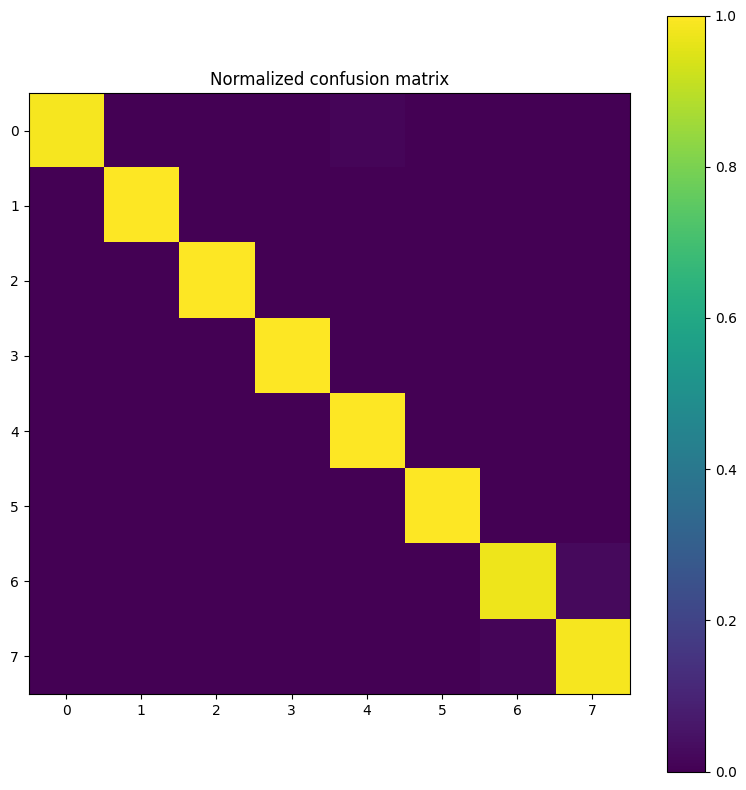

5-fold CV: mean=0.9875 std=0.0026
Saved centroids to embeddings_cache\centroids.npy and classes to embeddings_cache\classes.npy
Centroid baseline accuracy: 0.7316666666666667
Suggested cosine threshold for open-set (approx TPR=0.95): 0.4853


In [11]:
# Block 8 — evaluation: classification report, confusion matrix, 5-fold CV, centroid baseline, threshold
import pickle, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import normalize

# load saved classifier
obj = pickle.load(open(CLF_FILE, 'rb'))
clf = obj['clf']; le = obj['le']; norm = obj['norm']
X_test = obj['X_test']; y_test = obj['y_test']

# report
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred).astype(float)
cmn = cm / cm.sum(axis=1)[:, None]
plt.figure(figsize=(8,8)); plt.imshow(cmn); plt.title('Normalized confusion matrix'); plt.colorbar(); plt.tight_layout(); plt.show()

# 5-fold CV on full dataset
X_all = np.load(EMB_FILE); y_all = np.load(LBL_FILE, allow_pickle=True)
y_all_enc = le.transform(y_all); Xn_all = norm.transform(X_all)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accs = []
for tr, te in skf.split(Xn_all, y_all_enc):
    clf.fit(Xn_all[tr], y_all_enc[tr])
    accs.append(clf.score(Xn_all[te], y_all_enc[te]))
print("5-fold CV: mean={:.4f} std={:.4f}".format(np.mean(accs), np.std(accs)))

# centroid baseline
Xn_norm = normalize(X_all, axis=1)
centroids = {c: Xn_norm[y_all_enc==c].mean(axis=0) for c in np.unique(y_all_enc)}
# save centroids and classes for lightweight inference
centroid_matrix = np.vstack([centroids[c] for c in sorted(centroids.keys())])
classes_order = np.array([le.classes_[c] for c in sorted(centroids.keys())])
np.save(CENTROIDS_FILE, centroid_matrix)
np.save(CLASSES_FILE, classes_order)
print("Saved centroids to", CENTROIDS_FILE, "and classes to", CLASSES_FILE)

# centroid accuracy on same test split
from sklearn.model_selection import train_test_split
_, X_test_c, _, y_test_c = train_test_split(Xn_norm, y_all_enc, stratify=y_all_enc, test_size=0.15, random_state=42)
def predict_centroid(emb):
    emb = emb / np.linalg.norm(emb)
    sims = centroid_matrix.dot(emb)
    return sims.argmax(), sims.max()
y_cent = [predict_centroid(e)[0] for e in X_test_c]
print("Centroid baseline accuracy:", accuracy_score(y_test_c, y_cent))

# Open-set threshold suggestion: compute genuine vs impostor cosine scores on validation set
# Build per-class centroid from training portion and compute scores: simple approach using split
tr, val = next(StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(Xn_all, y_all_enc))
# compute centroids on tr
centroids_tr = {c: Xn_all[tr][y_all_enc[tr]==c].mean(axis=0) for c in np.unique(y_all_enc)}
# compute genuine scores and impostor scores on val set
genuine_scores = []
impostor_scores = []
for i, emb in enumerate(Xn_all[val]):
    label = y_all_enc[val][i]
    emb_norm = emb / np.linalg.norm(emb)
    sims = [emb_norm.dot(centroids_tr[c]) for c in centroids_tr]
    # genuine score = sim with true class centroid
    genuine_scores.append(emb_norm.dot(centroids_tr[label]))
    # impostor score = max sim to any other class centroid
    impostor_scores.append(max([s for c,s in zip(centroids_tr.keys(), sims) if c != label]))

genuine_scores = np.array(genuine_scores); impostor_scores = np.array(impostor_scores)
# compute ROC between genuine and impostor by labeling genuine=1, impostor=0 (stack arrays)
labels_scores = np.concatenate([np.ones_like(genuine_scores), np.zeros_like(impostor_scores)])
scores = np.concatenate([genuine_scores, impostor_scores])
fpr, tpr, thresholds = roc_curve(labels_scores, scores)
# pick threshold where tpr ~ 0.95 or where (tpr-fpr) is maximized
idx = (np.abs(tpr - 0.95)).argmin()
suggested_thresh = thresholds[idx]
print(f"Suggested cosine threshold for open-set (approx TPR=0.95): {suggested_thresh:.4f}")


In [12]:
# =========================================================
# Block 9.1 — inference helpers (SVM and centroid)
# Project: Mango Plant Disease Detection
# =========================================================

import numpy as np
import pickle
import torch
from PIL import Image
from sklearn.preprocessing import normalize

from app.config import (
    CLF_FILE,
    CENTROIDS_FILE,
    CLASSES_FILE,
    IMAGE_SIZE
)

from app.inference import extract_features

# -------- Load artifacts --------
obj = pickle.load(open(CLF_FILE, 'rb'))
clf = obj['clf']
le = obj['le']
norm = obj['norm']

centroid_matrix = np.load(CENTROIDS_FILE)
classes_order = np.load(CLASSES_FILE, allow_pickle=True)

# -------- SVM prediction --------
def predict_with_svm(image_path, top_k=3):
    emb = extract_features(image_path).reshape(1, -1)
    emb = norm.transform(emb)

    probs = clf.predict_proba(emb)[0]
    idx = probs.argsort()[::-1][:top_k]

    return [(le.classes_[i], float(probs[i])) for i in idx]

# -------- Centroid prediction --------
def predict_with_centroid(image_path, top_k=3):
    emb = extract_features(image_path)
    emb = emb / np.linalg.norm(emb)

    sims = centroid_matrix.dot(emb)
    idx = sims.argsort()[::-1][:top_k]

    return [(classes_order[i], float(sims[i])) for i in idx]

print("✅ Inference helpers ready (SVM + Centroid)")


✅ Inference helpers ready (SVM + Centroid)


In [13]:
# =========================================================
# Block 9.2 — centroid baseline evaluation
# =========================================================

import numpy as np
from sklearn.preprocessing import normalize, LabelEncoder
from sklearn.metrics import accuracy_score

# Load embeddings
X = np.load('./embeddings_cache/X_emb.npy', allow_pickle=True)
y = np.load('./embeddings_cache/y_lbl.npy', allow_pickle=True)

le = LabelEncoder().fit(y)
y_enc = le.transform(y)

# Normalize embeddings
Xn = normalize(X, axis=1)

# Compute centroids
centroids = {
    c: Xn[y_enc == c].mean(axis=0)
    for c in np.unique(y_enc)
}

def predict_centroid(emb):
    emb = emb / np.linalg.norm(emb)
    sims = [(c, emb.dot(centroids[c])) for c in centroids]
    return max(sims, key=lambda x: x[1])[0]

# Evaluate (requires X_test, y_test from earlier split)
try:
    y_pred = [predict_centroid(e) for e in X_test]
    print("Centroid accuracy on test:",
          accuracy_score(y_test, y_pred))
except NameError:
    print("⚠️ Run train/test split block first")


Centroid accuracy on test: 0.7316666666666667


In [15]:
# =========================================================
# Block 10 — Batch prediction & detailed CSV report
# =========================================================

import pandas as pd
import numpy as np
import pickle
from pathlib import Path
from tqdm import tqdm

from app.config import CLF_FILE, IMAGE_EXTENSIONS
from app.inference import extract_features

# ---------- EDIT THIS ----------
PREDICT_DIR = "data"
# ------------------------------

OUTPUT_CSV = "predictions_results.csv"
OUTPUT_SUMMARY_CSV = "predictions_summary.csv"

# Load model
obj = pickle.load(open(CLF_FILE, 'rb'))
clf = obj['clf']
le = obj['le']
norm = obj['norm']

PREDICT_PATH = Path(PREDICT_DIR)
image_paths = [
    p for p in PREDICT_PATH.rglob("*")
    if p.suffix.lower() in IMAGE_EXTENSIONS
]

print(f"Found {len(image_paths)} images")

results = []
failed = []

for img_path in tqdm(image_paths, desc="Predicting"):
    try:
        emb = extract_features(img_path).reshape(1, -1)
        emb = norm.transform(emb)

        pred_idx = clf.predict(emb)[0]
        pred_label = le.inverse_transform([pred_idx])[0]

        proba = clf.predict_proba(emb)[0]
        confidence = float(proba[pred_idx])

        top3_idx = proba.argsort()[::-1][:3]
        top3_labels = le.inverse_transform(top3_idx)
        top3_probs = proba[top3_idx]

        actual = img_path.parent.name
        correct = actual == pred_label

        results.append({
            "image_path": str(img_path),
            "filename": img_path.name,
            "actual": actual,
            "predicted": pred_label,
            "confidence": confidence,
            "correct": correct,
            "top1": top3_labels[0],
            "top1_conf": float(top3_probs[0]),
            "top2": top3_labels[1],
            "top2_conf": float(top3_probs[1]),
            "top3": top3_labels[2],
            "top3_conf": float(top3_probs[2]),
        })

    except Exception as e:
        failed.append((str(img_path), str(e)))

# -------- Save results --------
df = pd.DataFrame(results)
df.to_csv(OUTPUT_CSV, index=False)

summary = df.groupby("actual").agg(
    correct_count=("correct", "sum"),
    total_count=("correct", "count"),
)
summary["accuracy"] = summary["correct_count"] / summary["total_count"]
summary.to_csv(OUTPUT_SUMMARY_CSV)

print("✅ Prediction complete")
print(f"Saved: {OUTPUT_CSV}")
print(f"Saved: {OUTPUT_SUMMARY_CSV}")

if failed:
    pd.DataFrame(failed, columns=["image", "error"]).to_csv(
        "failed_predictions.csv", index=False
    )


Found 4000 images


Predicting:   0%|          | 0/4000 [00:00<?, ?it/s]

✅ Inference models loaded


Predicting: 100%|██████████| 4000/4000 [34:34<00:00,  1.93it/s]  


✅ Prediction complete
Saved: predictions_results.csv
Saved: predictions_summary.csv
